In [1]:
import matplotlib.pyplot as plt
import numpy as np
import typhon as ty
from scipy.constants import g, R
from scipy.integrate import solve_ivp

In [2]:
### some constants
mr_dry       = 0.0289647         # molecular mass (per 1 mole) of dry air (M_r)                 
mr_water     = 0.01801528        # molecular mass of water
rgas_dry     = R/mr_dry          # specific gas constant for dry air [J/Kg/K]      <-- used in ideal gas equation for hydrostsic rather than moist??
rgas_v       = R/mr_water        # specific gas constant for water
cp_dry       = 1006              # specific heat capacity (dry) air [J/Kg/K]         
latent_v     = 2.264705e6        # specific latent heat of vapourisation of water [J/Kg]

In [3]:
###  initial T, p and theta profiles
tempg        = 297.2             # temperature at ground level [K]
lps_rate     = 0.0062            # lapse rate above zb [K/km]
pb           = 95000             # pressure at cloud base [Pa]
zb           = 500               # height of cloud base [m]


def temp_pressure_profile(z): 
    '''model temperature and pressure 
       profiles for atmosphere'''
    
    if z<=zb:
        temp = tempg
        p = pb * np.exp( -g/(rgas_dry*tempg) * (z-zb))
    else:
        temp = tempg - lps_rate*(z-zb)
        p = pb * (1 - lps_rate/tempg*(z-zb))**(g/(rgas_dry*lps_rate))
      

    return temp, p


### initial parcel conditions
w                   = 2                                             # vertical wind speed [m/s]
pcl0_z              = 0                                             # initial z coordinate
pcl0_temp, pcl0_p   = temp_pressure_profile(pcl0_z)                 # initial temp & pressure
pcl0_relh           = 80                                            # initial relative humidity (%)
pcl0_qc             = 0                                             # initial liquid water content
cond                = False                                         # include condensation adjustment (or not)


### integration parameters
t_span, teval      = [0,1000], None
t_eval             = None
max_step           = 0.2                                            # max step of ODE solver (make less than dt_thermo)
dt_thermo          = 1                                              # time between collection of thermo data


### values of some variables as a result
pcl0_psat = ty.physics.e_eq_water_mk(pcl0_temp) 
pcl0_pv = pcl0_relh/100 * pcl0_psat                                 # initial water vapour pressure
pcl0_qv = mr_water/mr_dry * pcl0_pv/(pcl0_p-pcl0_pv)                # initial water mass mixing ratio (mass water/mass dry air)
y0                 = [pcl0_z]
pcl0_thermo        = [pcl0_temp, pcl0_p, pcl0_qv, pcl0_qc]
args               = [w, pcl0_thermo, cond]

In [4]:
def moist_static_energy(z, temp, qv=0, qc=0, dry=False):
    ''' calculate (not assuming dry air cp)
            the moist static energy '''
    
    # specific heat capacities to use [J/Kg/K]
    cp_dry       = 1006              # dry air       
    cp_v         = 1996              # water vapour 
    cp_l         = 4182              # liquid water
    
    if dry:
        heat_enthalpy = cp_dry*temp
    else:
        heat_enthalpy = ((1-qv-qc)*cp_dry + qv*cp_v + qc*cp_l)*temp
    
    return  g*z + latent_v*qv + heat_enthalpy

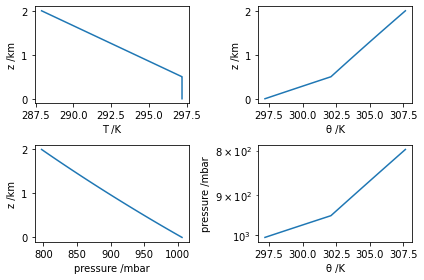

In [5]:
### plots of initial T, theta and pressure profiles

z = np.arange(0,2020,20)      # z coordinates of domain
temp_list, p_list = [], []
for x in z:
    temp, p = temp_pressure_profile(x)
    temp_list.append(temp)
    p_list.append(p)
temp = np.asarray(temp_list)
p = np.asarray(p_list)

theta = temp*(p[0]/p)**(rgas_dry/cp_dry)

fig, axs = plt.subplots(nrows=2, ncols=2)

axs[0,0].plot(temp, z/1000)
axs[0,0].set_xlabel('T /K')
axs[0,0].set_ylabel('z /km')

axs[1,0].plot(p/100, z/1000)
axs[1,0].set_xlabel('pressure /mbar')
axs[1,0].set_ylabel('z /km')

axs[0,1].plot(theta, z/1000)
axs[0,1].set_xlabel('\u03B8 /K')
axs[0,1].set_ylabel('z /km')

axs[1,1].plot(theta, p/100)
axs[1,1].set_xlabel('\u03B8 /K')
axs[1,1].set_ylabel('pressure /mbar')

axs[1,1].set_yscale('log')
axs[1,1].invert_yaxis()

plt.tight_layout()

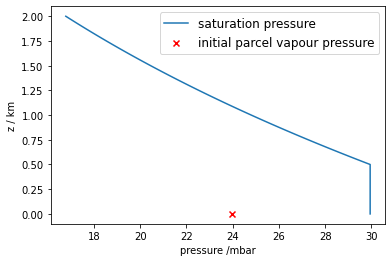

In [6]:
###  initial saturation pressure profile
p_sat = ty.physics.e_eq_water_mk(temp)

pcl0_qsat = mr_water/mr_dry * ty.physics.e_eq_water_mk(pcl0_temp)/pcl0_pv 
if pcl0_qsat < pcl0_qv:
    print('Parcel initially supersaturated')
    print('Initial mixing ratios:', pcl0_qv, pcl0_qsat)

fig, ax = plt.subplots()
ax.plot(p_sat/100, z/1000, label='saturation pressure')
ax.scatter(pcl0_pv/100, pcl0_z/1000, label='initial parcel vapour pressure', marker='x', color='r')
ax.set_xlabel('pressure /mbar')
ax.set_ylabel('z / km')
ax.legend(fontsize=12, loc='upper right')
plt.show()

In [7]:
### condensataion adjustment scheme

def cond_adjustment(z, temp, p, qv):
    ''' if saturation pressure p_sat < water vapour pressure pv
    return deltemp, delqv and delqc adjustments 
    required so that qv + delqv = q_sat '''
    
    p_sat = ty.physics.e_eq_water_mk(temp)          # saturation pressure of parcel
    pv = qv*p / (mr_water/mr_dry + qv)              # vapour pressure
    q_sat = mr_water/mr_dry * p_sat/(p-pv)
   
    deltemp, delqv = 0.0, 0.0                       # saturation not reached then no adjustment
    if qv > q_sat:
        frac = q_sat*latent_v**2/(cp_dry*rgas_dry*temp**2) 
        factor = 1/(1 + frac)
        delqv = -(qv-q_sat)*factor
        deltemp = latent_v/cp_dry * (-delqv)
        
    delqc = -delqv                                  # dqc = -dqv condesed liquid water = loss of vapour
    
    return deltemp, delqv, delqc 

In [8]:
t_thermo, z_thermo = [], []
temp_data, p_data, qv_data, qc_data, psat_data = [], [], [], [], []

def collect_thermo_data(t, z, temp, p, qv, qc):
    ''' add data to lists (after interval 
    dt_thermo since last addition)'''
    
    t_thermo.append(t)
    z_thermo.extend(z)
    temp_data.append(temp)
    p_data.append(p)
    qv_data.append(qv)
    qc_data.append(qc)
    psat_data.append(ty.physics.e_eq_water_mk(temp))
    
    
def parcel_rising_cond_included(t, z, w, pcl0_thermo,
        cond=True, tpop=[], thermopop=[]):
    ''' differential equations for rising parcel 
    (thermo)dynamics with condensation adjustment:
    Parcel rises, expands adiabatically and then
    condenses water if qv > q_sat at new temperature.
    Note: ODE solver only used to solve for motion, 
    iterative addition used for thermodynamcis'''

    
    ### dynamics of parcel
    #tau = 50*60                     # tau_w = 50min
    #dz = w*np.sin(2*np.pi*t/tau)
    dz = w

    if t == 0.0:
        temp, p, qv, qc = pcl0_thermo                             # initial temp, p, qv and qc of parcel (no thermo evolution yet)
        collect_thermo_data(t, z, temp, p, qv, qc)
    else:
        
        ### thermodynamics of parcel
        temp, p, qv, qc = thermopop.pop()
        t_m1 = tpop.pop()
        delt = t-t_m1                                            # delta t of dynamical timestep just completed = t - t_-1
    
        temp_surr, p_surr = temp_pressure_profile(z[0])          # surrounding temp and pressure
        p = p_surr                                               # instanataneous volume change to match pressure with surroundings
    
    
        # adiabatic thermo changes
        dtemp_dz =  (-g*pcl0_temp/cp_dry) * \
            (p/pcl0_p)**(rgas_dry/cp_dry) *1/temp_surr
        deltemp_a = dz * dtemp_dz *delt                            # delT = dT/dz * w * delt              # w = dz/dt
        
        temp+=deltemp_a
        
        
        # condensation adjustment
        if cond:
            deltemp_c, delqv, delqc = \
                cond_adjustment(z, temp, p, qv)    
            temp+=deltemp_c                                      # add temp change due to condensation to adiabatic change already computed
            qv+=delqv
            qc+=delqc
        #else:
        #   deltemp_c, delqv, delqc = 0, 0, 0

        # (redundant but useful) pressure calculation
        #delp = w * (-g*p_surr/(rgas_dry*temp_surr)) * delt        
        #p+=delp
        
        
    if (t-t_thermo[-1]) > dt_thermo:                             # collect data aas soon as dt_thermo < time elapsed since last collection
        collect_thermo_data(t, z, temp, p, qv, qc)
    
    tpop.append(t)                                               # for working out thermo after iteration of solver
    thermopop.append([temp,p,qv,qc])
    
    return [dz]
    

    
    
sol = solve_ivp(parcel_rising_cond_included, t_span, 
                    y0, method='RK45', max_step=max_step, 
                                t_eval=t_eval, args=args)   
time_sol, z_sol = sol.t, sol.y
time, z = t_thermo, np.asarray(z_thermo)
temp, p = np.asarray(temp_data), np.asarray(p_data), 
qv, qc, p_sat = np.asarray(qv_data),np.asarray(qc_data), np.asarray(psat_data)
theta = temp * (p/p[0])**(rgas_dry/cp_dry)
pv = qv*p / (mr_water/mr_dry + qv)  
relh = pv/p_sat 
moist_static_e = moist_static_energy(z, temp, qv=qv, qc=qc, dry=True)

In [9]:
### calculate surrounding temp and pressure profile for same (z,t) as parcel solution
temp_list, p_list = [], []
for x in z:
    temp_surr, p_surr = temp_pressure_profile(x)
    p_list.append(p_surr)
    temp_list.append(temp_surr)
temp_surr = np.asarray(temp_list)
p_surr = np.asarray(p_list)

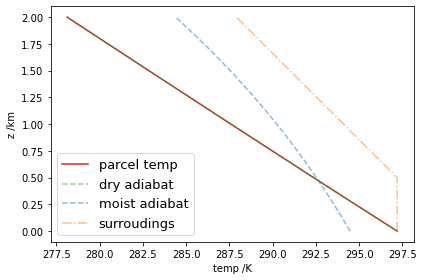

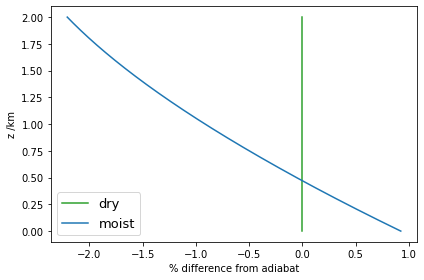

In [10]:
fig, ax1 = plt.subplots()

dry_adia = pcl0_temp*(p/pcl0_p)**(rgas_dry/cp_dry)

moist_lapse = ty.physics.moist_lapse_rate(p, temp, e_eq=None)
ind = np.where(relh==relh[relh>1][0])
moist_adia = temp[ind] - moist_lapse*(z-z[ind])

ax1.plot(temp, z/1000, color='C3', label='parcel temp')
ax1.plot(dry_adia,z/1000, '--', color='C2', alpha=0.5, label='dry adiabat')
ax1.plot(moist_adia,z/1000, '--', color='C0', alpha=0.5, label='moist adiabat')
ax1.plot(temp_surr,z/1000, linestyle='-.', color='C1',alpha=0.5, label='surroudings')
ax1.set_xlabel('temp /K')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13, loc='lower left')
plt.tight_layout()
plt.show()


fig, ax2 = plt.subplots()

ax2.plot((temp-dry_adia)/dry_adia*100, z/1000, color='C2', label='dry')
ax2.plot((temp-moist_adia)/moist_adia*100, z/1000, color='C0', label='moist')
ax2.set_xlabel('% difference from adiabat')
ax2.set_ylabel('z /km')
ax2.legend(fontsize=13, loc='lower left')
plt.tight_layout()
plt.show()

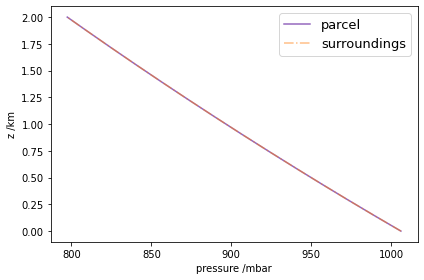

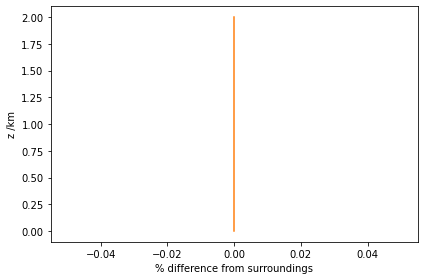

In [11]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

ax1.plot(p/100, z/1000, label='parcel', color='C4')
ax1.plot(p_surr/100, z/1000, linestyle='-.',alpha=0.5, color='C1', label='surroundings')
ax1.set_xlabel('pressure /mbar')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13)
plt.tight_layout()
plt.show()


fig, ax2 = plt.subplots(nrows=1, ncols=1)

ax2.plot((p-p_surr)/p_surr*100, z/1000, color='C1')
ax2.set_xlabel('% difference from surroundings')
ax2.set_ylabel('z /km')

plt.tight_layout()
plt.show()

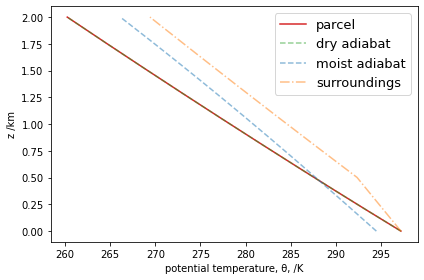

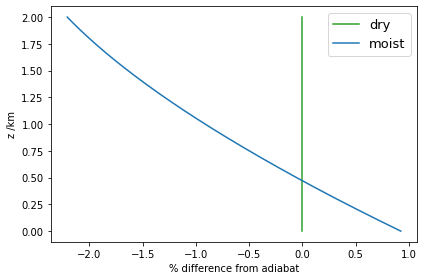

In [12]:
fig, ax1 = plt.subplots(nrows=1, ncols=1)

theta_dry_adia = dry_adia * (p/p[0])**(rgas_dry/cp_dry)
theta_surr = temp_surr * (p_surr/p[0])**(rgas_dry/cp_dry)
theta_moist_adia = moist_adia * (p/p[0])**(rgas_dry/cp_dry)

ax1.plot(theta, z/1000, color='C3', label='parcel')
ax1.plot(theta_dry_adia, z/1000, '--', alpha=0.5, color='C2', label='dry adiabat')
ax1.plot(theta_moist_adia, z/1000, '--', alpha=0.5, color='C0', label='moist adiabat')
ax1.plot(theta_surr, z/1000, linestyle='-.', alpha=0.5, color='C1', label='surroundings')
ax1.set_xlabel('potential temperature, \u03B8, /K')
ax1.set_ylabel('z /km')
ax1.legend(fontsize=13)
plt.tight_layout()
plt.show()

fig, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot((theta-theta_dry_adia)/theta_dry_adia*100, z/1000, color='C2', label='dry')
ax2.plot((theta-theta_moist_adia)/theta_moist_adia*100, z/1000, color='C0', label='moist')
ax2.set_xlabel('% difference from adiabat')
ax2.set_ylabel('z /km')
ax2.legend(fontsize=13)
plt.tight_layout()
plt.show()

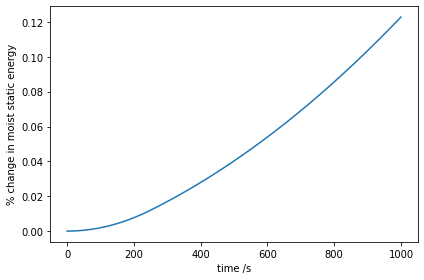

In [13]:
fig, ax2 = plt.subplots(nrows=1, ncols=1)
ax2.plot(time, (moist_static_e-moist_static_e[0])/moist_static_e[0]*100)
ax2.set_ylabel('% change in moist static energy')
ax2.set_xlabel('time /s')

plt.tight_layout()
plt.show()